In [1]:
import torch; print(torch.__version__); print(torch.cuda.is_available())

/home/wang.zhi4/.conda/envs/7980_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.0
True


In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

import matplotlib.pyplot as plt
torch.set_float32_matmul_precision('high')

In [3]:
# 1. Dataset Definition 

def min_max_normalize(data, min_val=None, max_val=None):
    """ Manually Min-Max normalize to [0,1] """
    if min_val is None:
        min_val = np.min(data, axis=-1, keepdims=True)
    if max_val is None:
        max_val = np.max(data, axis=-1, keepdims=True)
    return (data - min_val) / (max_val - min_val + 1e-8), min_val, max_val

def min_max_denormalize(data, min_val, max_val):
    """ Denormalize back to original range """
    return data * (max_val - min_val) + min_val

class SLD_NR_Dataset(Dataset):
    def __init__(self, sld_file, nr_file):
        # 1) Load raw data
        sld_data = np.load(sld_file)  # (N, 2, 900)
        nr_data = np.load(nr_file)    # (N, 2, 308)

        # 2) Extract X/Y axes data for SLD and NR
        sld_z, sld_values = sld_data[:, 0, :], sld_data[:, 1, :]
        nr_q, nr_r = nr_data[:, 0, :], nr_data[:, 1, :]

        # 3) Log10 transform of NR data
        nr_r_log = np.log10(np.clip(nr_r, 1e-9, None))  # Avoid log(0)

        # 4) Manually Min-Max normalize
        self.sld_z_norm, self.sld_z_min, self.sld_z_max = min_max_normalize(sld_z)
        self.sld_values_norm, self.sld_values_min, self.sld_values_max = min_max_normalize(sld_values)

        self.nr_q_norm, self.nr_q_min, self.nr_q_max = min_max_normalize(nr_q)
        self.nr_r_norm, self.nr_r_min, self.nr_r_max = min_max_normalize(nr_r_log)

        # 5) Combine normalized data
        sld_data_normalized = np.stack([self.sld_z_norm, self.sld_values_norm], axis=1)
        nr_data_normalized = np.stack([self.nr_q_norm, self.nr_r_norm], axis=1)

        # 6) Convert to float32
        self.sld_data = sld_data_normalized.astype(np.float32)
        self.nr_data = nr_data_normalized.astype(np.float32)

    def __len__(self):
        return len(self.sld_data)

    def __getitem__(self, idx):
        sld = torch.tensor(self.sld_data[idx], dtype=torch.float32)
        nr = torch.tensor(self.nr_data[idx], dtype=torch.float32)
        return sld, nr

    def inverse_transform_sld(self, sld_norm):
        """ Denormalize SLD data """
        sld_z_original = min_max_denormalize(sld_norm[:, 0, :], self.sld_z_min, self.sld_z_max)
        sld_values_original = min_max_denormalize(sld_norm[:, 1, :], self.sld_values_min, self.sld_values_max)
        return np.stack([sld_z_original, sld_values_original], axis=1)

    def inverse_transform_nr(self, nr_norm):
        """ Denormalize NR data """
        nr_q_original = min_max_denormalize(nr_norm[:, 0, :], self.nr_q_min, self.nr_q_max)
        nr_r_original = min_max_denormalize(nr_norm[:, 1, :], self.nr_r_min, self.nr_r_max)
        nr_r_original = 10 ** nr_r_original  # Inverse log10
        return np.stack([nr_q_original, nr_r_original], axis=1)


In [4]:
#########################################
# 2. Improved 1D Conditional U-Net
#########################################
class ConditionalUnet1D(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim=256, base_channels=64):
        super().__init__()
        self.time_dim = time_dim
        self.base_channels = base_channels
        # Downsampling part
        self.conv1 = nn.Conv1d(in_channels, base_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(base_channels, base_channels*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(base_channels*2, base_channels*4, kernel_size=3, padding=1)
        self.downsample = nn.MaxPool1d(2)

        # Upsampling part
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv_mid = nn.Conv1d(base_channels*4, base_channels*4, kernel_size=3, padding=1)
        self.conv_up1 = nn.Conv1d(base_channels*4 + base_channels*2, base_channels*2, kernel_size=3, padding=1)
        self.conv_up2 = nn.Conv1d(base_channels*2 + base_channels, base_channels, kernel_size=3, padding=1)
        self.conv_final = nn.Conv1d(base_channels, out_channels, kernel_size=3, padding=1)

        # Time step embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_dim),
            nn.ReLU(),
            nn.Linear(time_dim, time_dim)
        )
        # Project the time embedding to the bottleneck channel size
        self.time_proj = nn.Linear(time_dim, base_channels*4)

    def forward(self, x, t, cond_emb=None):
        """
        x: [batch, in_channels, length]  # e.g. [batch, 2, 900]
        t: [batch] (scalar time step)
        cond_emb: [batch, time_dim] (encoded NR condition)
        """
        t = t.unsqueeze(-1).float()        # [batch, 1]
        time_emb = self.time_mlp(t)        # [batch, time_dim]
        if cond_emb is not None:
            time_emb = time_emb + cond_emb # combine condition + time emb
        time_bias = self.time_proj(time_emb).unsqueeze(-1)  # [batch, base_channels*4, 1]

        # Downsampling path
        x1 = F.relu(self.conv1(x))         # [batch, base_channels, length]
        x2 = self.downsample(x1)           # [batch, base_channels, length/2]
        x2 = F.relu(self.conv2(x2))        # [batch, base_channels*2, length/2]
        x3 = self.downsample(x2)           # [batch, base_channels*2, length/4]
        x3 = F.relu(self.conv3(x3))        # [batch, base_channels*4, length/4]

        # Bottleneck with time_bias
        x_mid = F.relu(self.conv_mid(x3 + time_bias))  # [batch, base_channels*4, length/4]

        # Upsampling path
        x_up = self.upsample(x_mid)        # [batch, base_channels*4, length/2]
        x_up = torch.cat([x_up, x2], dim=1) # skip connection
        x_up = F.relu(self.conv_up1(x_up))
        x_up = self.upsample(x_up)         # [batch, base_channels*2, length]
        x_up = torch.cat([x_up, x1], dim=1)
        x_up = F.relu(self.conv_up2(x_up))
        out = self.conv_final(x_up)        # [batch, out_channels, length]
        return out

In [5]:
#########################################
# 3. Conditional Diffusion Model
#########################################
class ConditionalDiffusionModel(pl.LightningModule):
    def __init__(self, t_range, img_channels, nr_dim, time_dim=256, base_channels=64):
        super().__init__()
        self.beta_small = 1e-4
        self.beta_large = 0.02
        self.t_range = t_range
        self.img_channels = img_channels
        self.time_dim = time_dim

        # 1D Conditional U-Net
        self.unet = ConditionalUnet1D(
            in_channels=img_channels, out_channels=img_channels,
            time_dim=time_dim, base_channels=base_channels
        )
        # Condition encoder: maps flattened NR curves to time_dim
        self.cond_encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nr_dim, time_dim),
            nn.ReLU(),
            nn.Linear(time_dim, time_dim)
        )

    def beta(self, t):
        return self.beta_small + (t / self.t_range) * (self.beta_large - self.beta_small)

    def alpha(self, t):
        return 1 - self.beta(t)

    def alpha_bar(self, t):
        # Product of alphas from 0..t
        alphas = [self.alpha(i) for i in range(t+1)]
        prod = 1.0
        for a in alphas:
            prod *= a
        return prod

    def forward(self, x, t, cond):
        """
        x: [batch, 2, 900] noisy SLD
        t: [batch]
        cond: [batch, 2, 308] NR condition
        """
        cond_flat = cond.view(cond.size(0), -1)      # [batch, 2*308]
        cond_emb = self.cond_encoder(cond_flat)      # [batch, time_dim]
        return self.unet(x, t, cond_emb=cond_emb)

    def training_step(self, batch, batch_idx):
        sld, nr = batch
        batch_size = sld.size(0)
        device = sld.device

        # random diffusion steps
        t = torch.randint(0, self.t_range, (batch_size,), device=device)
        noise = torch.randn_like(sld, device=device)
        noisy_imgs = []
        for i in range(batch_size):
            a_bar = self.alpha_bar(t[i].item())
            # x_t = sqrt(a_bar)*x_0 + sqrt(1-a_bar)* noise
            noisy = math.sqrt(a_bar)*sld[i] + math.sqrt(1 - a_bar)*noise[i]
            noisy_imgs.append(noisy)
        noisy_imgs = torch.stack(noisy_imgs, dim=0)

        # predict noise
        pred_noise = self.forward(noisy_imgs, t, nr)
        loss = F.mse_loss(pred_noise, noise)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        sld, nr = batch
        batch_size = sld.size(0)
        device = sld.device

        t = torch.randint(0, self.t_range, (batch_size,), device=device)
        noise = torch.randn_like(sld, device=device)
        noisy_imgs = []
        for i in range(batch_size):
            a_bar = self.alpha_bar(t[i].item())
            noisy = math.sqrt(a_bar)*sld[i] + math.sqrt(1 - a_bar)*noise[i]
            noisy_imgs.append(noisy)
        noisy_imgs = torch.stack(noisy_imgs, dim=0)

        pred_noise = self.forward(noisy_imgs, t, nr)
        loss = F.mse_loss(pred_noise, noise)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=2e-4, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

    # ============ Additional: sampling method ============
    def sample(self, cond, device, sample_steps=None):
        """
        cond: [batch, 2, 308] (NR condition)
        device: torch.device
        sample_steps: number of reverse diffusion steps (if None, use self.t_range)
        return: [batch, 2, 900] generated SLD
        """
        if sample_steps is None:
            sample_steps = self.t_range
        batch_size = cond.size(0)
        # start from pure noise
        x = torch.randn(batch_size, self.img_channels, 900, device=device)

        for step in reversed(range(sample_steps)):
            t_tensor = torch.full((batch_size,), step, device=device, dtype=torch.long)
            # predict noise
            pred_noise = self.forward(x, t_tensor, cond)
            a = self.alpha(step)
            a_bar = self.alpha_bar(step)

            if step > 0:
                # random noise
                noise = torch.randn_like(x)
            else:
                noise = 0

            # DDPM step
            # x_{t-1} = 1/sqrt(a) [ x_t - (1-a)/sqrt(1-a_bar)*pred_noise ] + sqrt(beta_t)*z
            x = (1 / math.sqrt(a))*(x - (1 - a)/math.sqrt(1 - a_bar)*pred_noise) + math.sqrt(self.beta(step))*noise

        return x  # shape [batch, 2, 900]

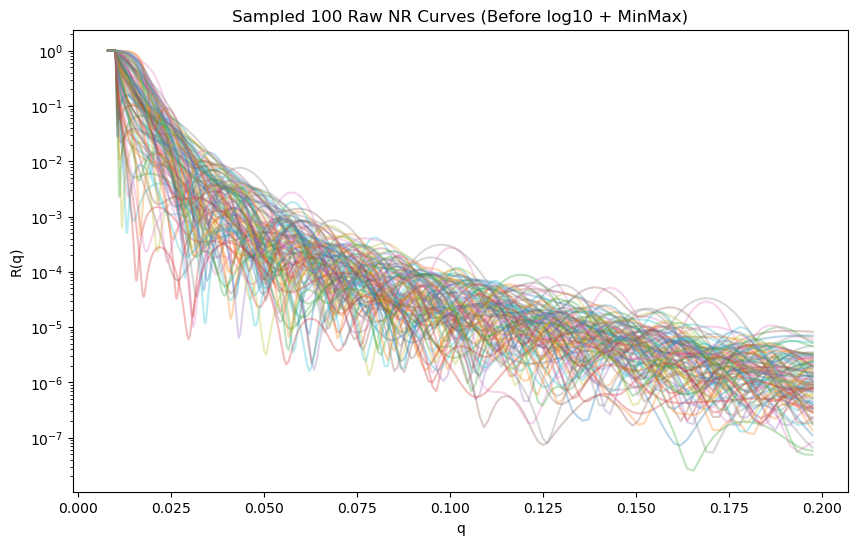

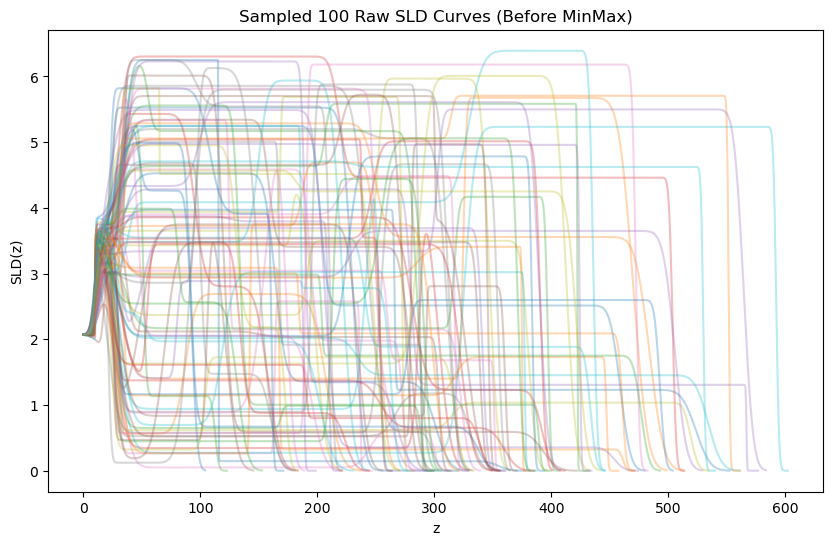

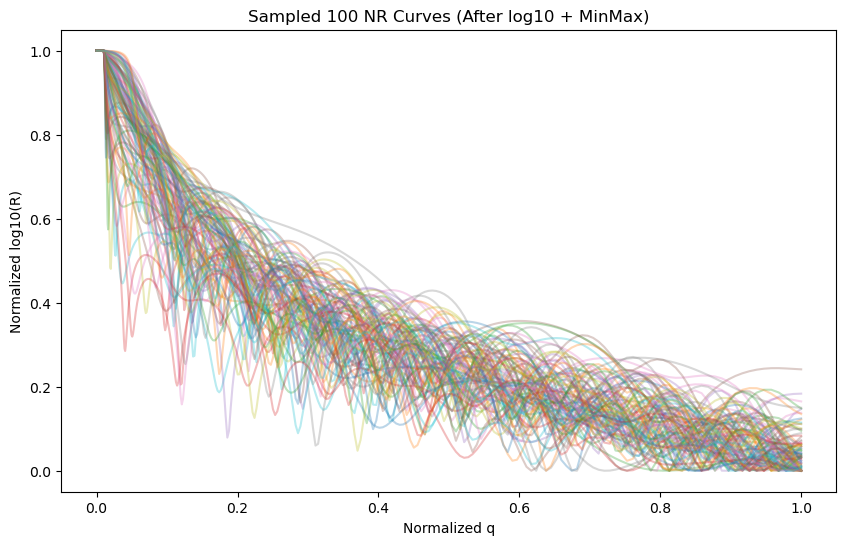

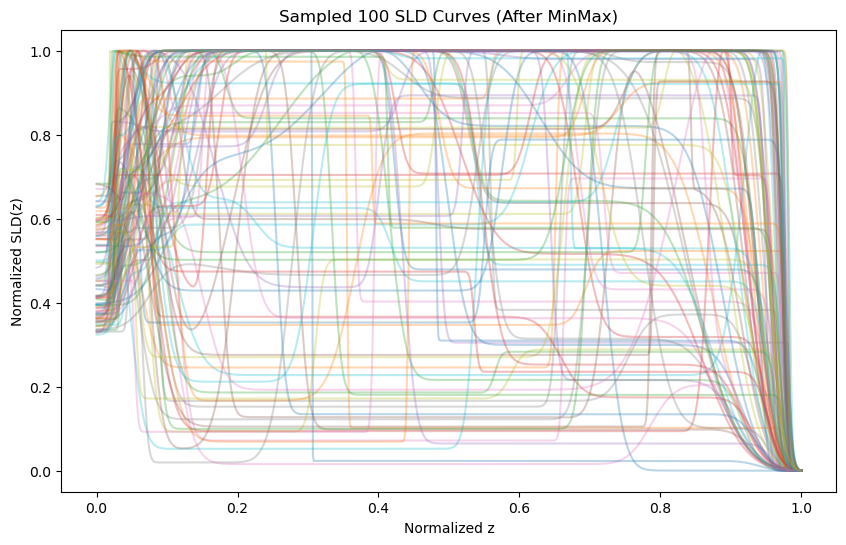

/home/wang.zhi4/.conda/envs/7980_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wang.zhi4/.conda/envs/7980_env/lib/python3.10/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params
---------------------------------------------------
0 | unet         | ConditionalUnet1D | 637 K 
1 | cond_encoder | Sequential        | 223 K 
---------------------------------------------------
861 K     Trainable params
0         Non-trainable params
861 K     Total params
3.445     Total estimated model params size (MB)
Metric val_loss improved. New best score

Training finished. Model saved to cond_ddpm_final.ckpt


In [6]:
# 4. Main Program
if __name__ == "__main__":
    from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

    # sld_path = "SLD_CurvesPolySpecial.npy"
    # nr_path  = "NR-SLD_CurvesPolySpecial.npy"

    sld_path = "SLD_CurvesPoly11.npy"
    nr_path  = "NR-SLD_CurvesPoly11.npy"

    # 4.1 Construct the dataset
    dataset = SLD_NR_Dataset(sld_path, nr_path)

    # 4.2 Read raw data
    raw_sld = np.load(sld_path)  # shape: (N, 2, 900) -> (z, SLD(z))
    raw_nr  = np.load(nr_path)   # shape: (N, 2, 308) -> (q, R(q))

    np.random.seed(42)
    random_indices = np.random.choice(len(dataset), size=100, replace=False)

    # ========== Plot Raw NR Curves ==========
    plt.figure(figsize=(10, 6))
    for idx in random_indices:
        q_values = raw_nr[idx][0]  # raw q
        r_values = raw_nr[idx][1]  # raw R(q)
        plt.plot(q_values, r_values, alpha=0.3)
    plt.title("Sampled 100 Raw NR Curves (Before log10 + MinMax)")
    plt.xlabel("q")
    plt.ylabel("R(q)")
    plt.yscale("log")  # NR data often require a log scale
    plt.show()

    # ========== Plot Raw SLD Curves ==========
    plt.figure(figsize=(10, 6))
    for idx in random_indices:
        z_values = raw_sld[idx][0]  # raw z
        sld_values = raw_sld[idx][1]  # raw SLD(z)
        plt.plot(z_values, sld_values, alpha=0.3)
    plt.title("Sampled 100 Raw SLD Curves (Before MinMax)")
    plt.xlabel("z")
    plt.ylabel("SLD(z)")
    plt.show()

    # ========== Plot Normalized NR Curves ==========
    plt.figure(figsize=(10, 6))
    for idx in random_indices:
        sld_sample, nr_sample = dataset[idx]
        plt.plot(nr_sample[0].numpy(), nr_sample[1].numpy(), alpha=0.3)
    plt.title("Sampled 100 NR Curves (After log10 + MinMax)")
    plt.xlabel("Normalized q")
    plt.ylabel("Normalized log10(R)")
    plt.show()

    # ========== Plot Normalized SLD Curves ==========
    plt.figure(figsize=(10, 6))
    for idx in random_indices:
        sld_sample, nr_sample = dataset[idx]
        plt.plot(sld_sample[0].numpy(), sld_sample[1].numpy(), alpha=0.3)
    plt.title("Sampled 100 SLD Curves (After MinMax)")
    plt.xlabel("Normalized z")
    plt.ylabel("Normalized SLD(z)")
    plt.show()

    # 4.3 Dataset Split
    train_size = int(0.9 * len(dataset))
    val_size   = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              num_workers=4, persistent_workers=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, 
                              num_workers=4, persistent_workers=True)

    # 4.4 Build Model + Training
    t_range = 1000
    model = ConditionalDiffusionModel(
        t_range=t_range, img_channels=2, nr_dim=2*308,
        time_dim=256, base_channels=64
    )

    # Early stopping mechanism
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        patience=50,
        mode="min",
        verbose=True
    )
    # Model checkpoint
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        filename="conditional-ddpm-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        mode="min"
    )

    trainer = pl.Trainer(
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1 if torch.cuda.is_available() else "auto",
        enable_progress_bar=False,
        max_epochs=50,
        log_every_n_steps=1000,  # Only log at the end of each epoch
        callbacks=[early_stop_callback, checkpoint_callback]
    )
    trainer.fit(model, train_loader, val_loader)

    # Save the final model after training (optional)
    trainer.save_checkpoint("cond_ddpm_final.ckpt")
    print("Training finished. Model saved to cond_ddpm_final.ckpt")

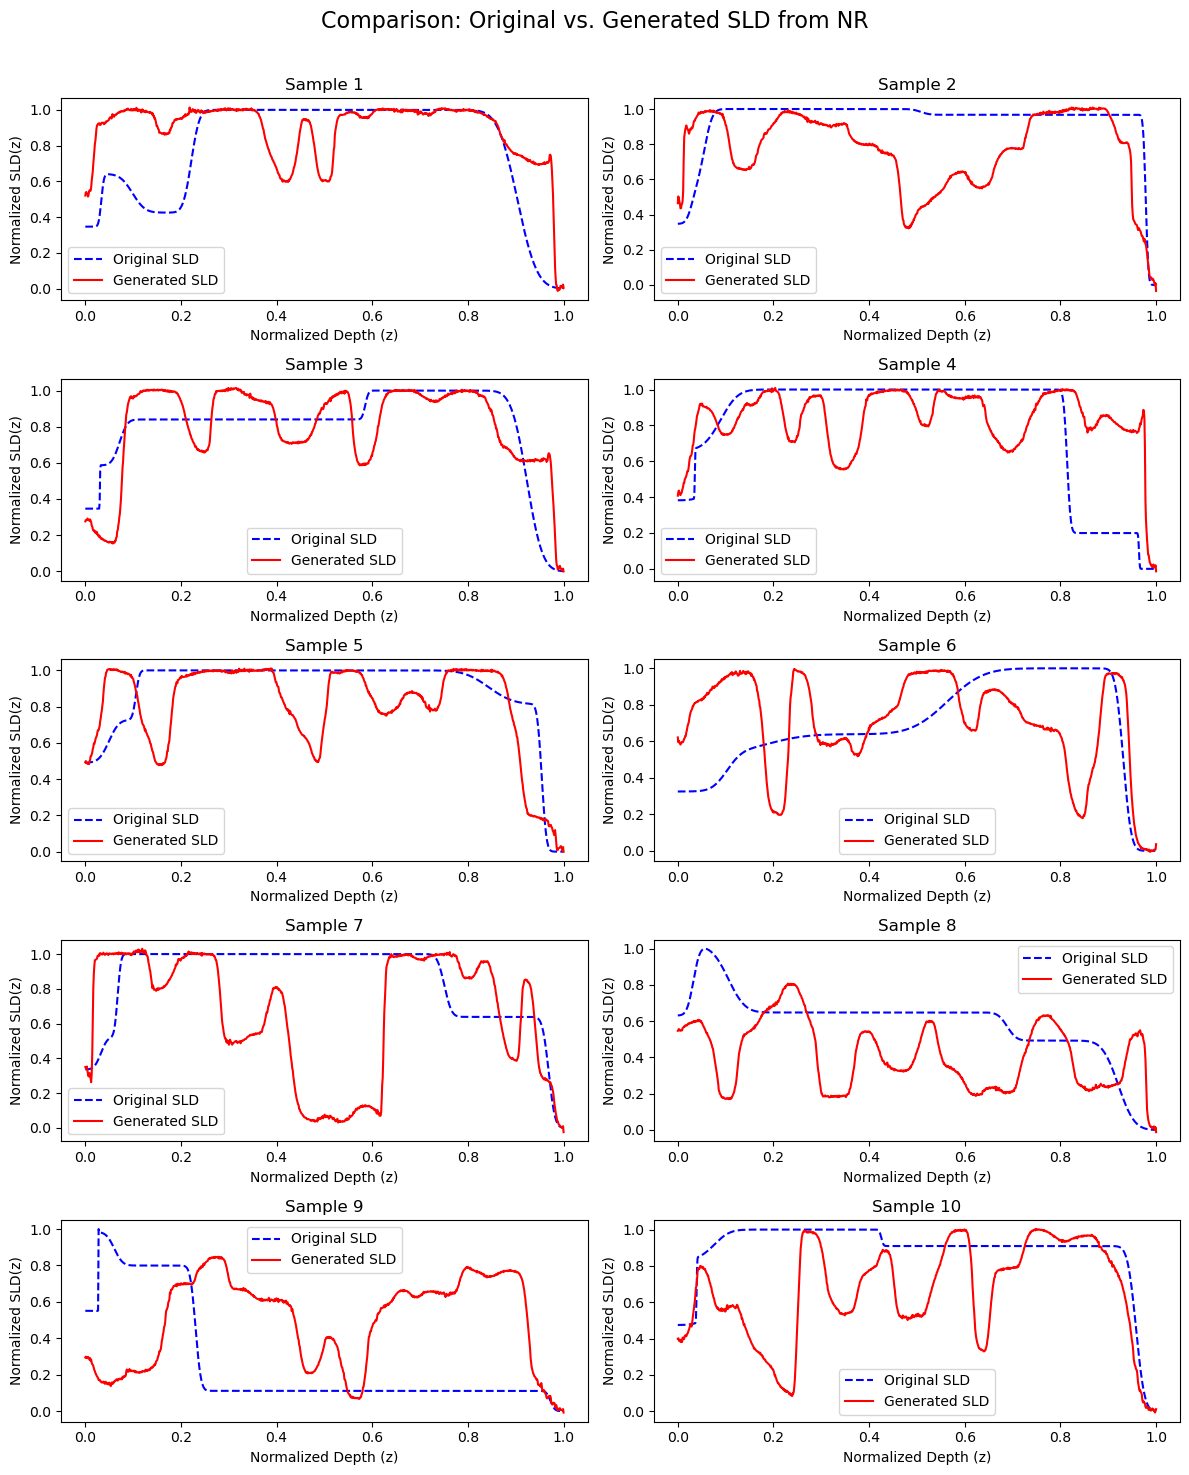

In [9]:
# 5. Load Model & Generate SLD from NR
import random

if True:  # Considered as a new code block, can be modified as needed
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Reload the model
    model = ConditionalDiffusionModel(
        t_range=1000, img_channels=2, nr_dim=2*308,
        time_dim=256, base_channels=64
    )

    checkpoint_path = "cond_ddpm_final.ckpt"
    # Map loaded weights to the correct device
    state_dict = torch.load(checkpoint_path, map_location=device)['state_dict']
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    # 2) Randomly select 10 sets of data from the validation set
    random_indices = random.sample(range(len(val_dataset)), 10)
    selected_data = [val_dataset[i] for i in random_indices]

    original_sld_list = []  # Original SLD
    generated_sld_list = [] # Generated SLD
    nr_list = []            # NR conditions

    with torch.no_grad():
        for sld, nr in selected_data:
            sld = sld.unsqueeze(0).to(device)  # [1, 2, 900]
            nr  = nr.unsqueeze(0).to(device)   # [1, 2, 308]

            # Record original SLD
            original_sld_list.append(sld.squeeze(0).cpu().numpy())

            # Generate SLD
            generated_sld = model.sample(nr, device=device, sample_steps=1000)  # [1, 2, 900]
            generated_sld_list.append(generated_sld.squeeze(0).cpu().numpy())

            # Record NR
            nr_list.append(nr.squeeze(0).cpu().numpy())

    # 3) Draw comparison graphs
    fig, axes = plt.subplots(5, 2, figsize=(12, 15))  # 5 rows, 2 columns, total 10 sets
    fig.suptitle("Comparison: Original vs. Generated SLD from NR", fontsize=16)

    for i in range(10):
        ax = axes[i // 2, i % 2]  # 5 rows, 2 columns, map by index
        z_values = np.linspace(0, 1, 900)  # Normalized Z axis

        ax.plot(z_values, original_sld_list[i][1], label="Original SLD", linestyle='dashed', color='blue')
        ax.plot(z_values, generated_sld_list[i][1], label="Generated SLD", linestyle='solid', color='red')
        ax.set_title(f"Sample {i+1}")
        ax.set_xlabel("Normalized Depth (z)")
        ax.set_ylabel("Normalized SLD(z)")
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()